In [2]:
import pandas as pd
import numpy as np

# Read in friendly international fixtures
friendly_int = pd.read_csv('flashscore_friendly_int.csv')

home_teams = friendly_int['home_team'].unique()
away_teams = friendly_int['away_team'].unique()

# Concatenate the arrays and keep unique values
unique_teams = np.unique(np.concatenate((home_teams, away_teams)))

# Create the mapping
team_mapping = {team: idx for idx, team in enumerate(unique_teams)}

# Reverse the mapping for easier lookup of team names by index
index_to_team = {v: k for k, v in team_mapping.items()}

# Map the categories to numbers
friendly_int['home_num'] = friendly_int['home_team'].map(team_mapping)
friendly_int['away_num'] = friendly_int['away_team'].map(team_mapping)

# Create a new column for both penalties and drop goals
# Drop goals are quite rare - think they can be grouped with penalty
friendly_int['Home_pg_dg'] = (friendly_int['Home_pg'] + friendly_int['Home_dg'])
friendly_int['Away_pg_dg'] = (friendly_int['Away_pg'] + friendly_int['Away_dg'])

# Need to update some of the conversion columns
# When there is a penalty try they don't count the conversions
friendly_int['manual_score_home'] = (friendly_int['Home_tries']*5 
                                + friendly_int['Home_conv']*2
                                + friendly_int['Home_pg_dg']*3)

friendly_int['manual_score_away'] = (friendly_int['Away_tries']*5 
                                + friendly_int['Away_conv']*2
                                + friendly_int['Away_pg_dg']*3)

# calculate differences
friendly_int['Home_diff'] = friendly_int['home_score'] - friendly_int['manual_score_home'] 
friendly_int['Away_diff'] = friendly_int['away_score'] - friendly_int['manual_score_away'] 



In [10]:
friendly_int['home_team']

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'key',
       'Home_tries', 'Away_tries', 'Home_conv', 'Away_conv', 'Home_conv_att',
       'Away_conv_att', 'Home_pg', 'Away_pg', 'Home_pg_att', 'Away_pg_att',
       'Home_dg', 'Away_dg', 'Home_dg_att', 'Away_dg_att', 'home_num',
       'away_num', 'Home_pg_dg', 'Away_pg_dg', 'manual_score_home',
       'manual_score_away', 'Home_diff', 'Away_diff'],
      dtype='object')

In [3]:
# Find examples where I have to update Home
friendly_int[friendly_int['Home_diff'] != 0][['home_score','manual_score_home','Home_diff']]

,home_score,manual_score_home,Home_diff
7,18,16,2
16,33,31,2
22,28,26,2
23,41,39,2


In [4]:
# Row indices to update
row_indices = [7, 16,22,23] 

# Increase Home conversion by 1
friendly_int.loc[row_indices, 'Home_conv'] += 1



In [6]:
# Rerun this code again to check for differences
friendly_int['manual_score_home'] = (friendly_int['Home_tries']*5 
                                + friendly_int['Home_conv']*2
                               + friendly_int['Home_pg_dg']*3)

friendly_int['manual_score_away'] = (friendly_int['Away_tries']*5 
                                + friendly_int['Away_conv']*2
                                + friendly_int['Away_pg_dg']*3)

# calculate differences
friendly_int['Home_diff'] = friendly_int['home_score'] - friendly_int['manual_score_home'] 
friendly_int['Away_diff'] = friendly_int['away_score'] - friendly_int['manual_score_away'] 

# print home diff
print(friendly_int[friendly_int['Home_diff'] != 0])
# print away diff
print(friendly_int[friendly_int['Away_diff'] != 0])


Empty DataFrame
Columns: [date, home_team, away_team, home_score, away_score, key, Home_tries, Away_tries, Home_conv, Away_conv, Home_conv_att, Away_conv_att, Home_pg, Away_pg, Home_pg_att, Away_pg_att, Home_dg, Away_dg, Home_dg_att, Away_dg_att, home_num, away_num, Home_pg_dg, Away_pg_dg, manual_score_home, manual_score_away, Home_diff, Away_diff]
Index: []

[0 rows x 28 columns]
Empty DataFrame
Columns: [date, home_team, away_team, home_score, away_score, key, Home_tries, Away_tries, Home_conv, Away_conv, Home_conv_att, Away_conv_att, Home_pg, Away_pg, Home_pg_att, Away_pg_att, Home_dg, Away_dg, Home_dg_att, Away_dg_att, home_num, away_num, Home_pg_dg, Away_pg_dg, manual_score_home, manual_score_away, Home_diff, Away_diff]
Index: []

[0 rows x 28 columns]


In [7]:
# Create arrays to be used by PYMC
# Home tries and away tries have variance greater than mean
# Conversion is Binomial Model
# Penalties could also be Negative Binomial

home_score_arr = friendly_int['home_score'].values
away_score_arr = friendly_int['away_score'].values
home_team = friendly_int['home_num'].values
away_team = friendly_int['away_num'].values
home_tries = friendly_int['Home_tries'].values
away_tries = friendly_int['Away_tries'].values
home_conv = friendly_int['Home_conv'].values
away_conv = friendly_int['Away_conv'].values
home_pg_dg = friendly_int['Home_pg_dg'].values
away_pg_dg = friendly_int['Away_pg_dg'].values




In [61]:
len(home_tries)

25

In [63]:
dud_data =  np.full(25, 12)

print(dud_data)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12]


In [66]:
# Combine into a DataFrame
home_tries_conv = pd.DataFrame({
    'team': friendly_int['home_team'].values,
    'tries': home_tries,
    'conv': home_conv,
    'conv_per': (home_conv/home_tries),
    'mock_per': (home_conv/12)
})

away_tries_conv = pd.DataFrame({
    'team': friendly_int['away_team'].values,
    'tries': away_tries,
    'conv': away_conv,
    'conv_per': (away_conv/away_tries),
     'mock_per': (away_conv/12)
})

# Concatenate along rows (union)
union_conv = pd.concat([home_tries_conv, away_tries_conv])


C:\Users\killi\AppData\Local\Temp\ipykernel_11680\3534139871.py:6: RuntimeWarning: invalid value encountered in divide
  'conv_per': (home_conv/home_tries),


In [21]:
print('mean all: ',union_conv['conv_per'].mean())
print('mean home: ',home_tries_conv['conv_per'].mean())
print('mean away: ',away_tries_conv['conv_per'].mean())

mean all:  0.7703207671957673
mean home:  0.7094893029675639
mean away:  0.8262857142857143


In [67]:
print('mean all: ',union_conv['mock_per'].mean())
print('mean home: ',home_tries_conv['mock_per'].mean())
print('mean away: ',away_tries_conv['mock_per'].mean())

mean all:  0.24833333333333332
mean home:  0.23000000000000004
mean away:  0.26666666666666666


In [18]:
union_conv.sort_values(by='conv_per', ascending=False)

,team,tries,conv,conv_per
1,Japan,2,2,1.000000
13,Portugal,3,3,1.000000
3,New Zealand,2,2,1.000000
2,Australia,1,1,1.000000
0,Australia,1,1,1.000000
24,Japan,2,2,1.000000
23,South Africa,5,5,1.000000
22,Uruguay,4,4,1.000000
21,USA,1,1,1.000000
18,Japan,2,2,1.000000


In [25]:
# home tries
print('home tries mean: ',np.mean(home_tries))
print('home tries var: ',np.var(home_tries))

# home penalty
# was 1.52 and 4
print('home pg dg mean: ',np.mean(home_pg_dg))
print('home pg dg var: ',np.var(home_pg_dg))

# Away tries
print('away tries mean: ',np.mean(away_tries))
print('away tries var: ', np.var(away_tries))

# away penalty
# was 1.68 and 2.77
print('away pg dg mean: ',np.mean(away_pg_dg))
print('away pg dg var: ',np.var(away_pg_dg))



home tries mean:  3.68
home tries var:  6.937600000000001
home pg dg mean:  1.56
home pg dg var:  3.9263999999999992
away tries mean:  4.0
away tries var:  8.8
away pg dg mean:  1.76
away pg dg var:  3.3024


In [24]:
# get number of teams
n_teams = len(unique_teams)
print(n_teams)

18


In [80]:
# Try create a simple Model that predicts conversion rate
# Use Negative Binomial Model

import pymc as pm

# Create Model
with pm.Model() as kicker_model:

    # Create a parameter for kickers - put in a really wide standard deviation on the mean
    # centered around 0 - gives quite a range at 0 as well - may need to change centre to 1
    kick_mu = pm.Normal("kick_mu", 0, 3)
    # This is standard deviation among the kickers
    kick_sd = pm.HalfNormal("kick_sd", 3)
    kick = pm.Normal("kick", mu=kick_mu, sigma=kick_sd, shape=n_teams)
    

    # Get p for home conv and away
    # This converts the kicking score from above into a probability between 0 and 1
    p_home_conv = pm.Deterministic("p_home_conv", pm.math.invlogit(kick[home_team] ))
    p_away_conv = pm.Deterministic("p_away_conv", pm.math.invlogit(kick[away_team] ) )
    
    # Binomial Model
    # n is number of trials, trying to estimate p, 
    home_conv_bin =  pm.Binomial("home_conv", n=home_tries, p=p_home_conv, observed= home_conv)
    away_conv_bin =  pm.Binomial("away_conv", n=away_tries, p=p_away_conv, observed= away_conv)

    
    
    # Get prior samples
    prior_samples = pm.sample_prior_predictive(100)


Sampling: [away_conv, home_conv, kick, kick_mu, kick_sd]


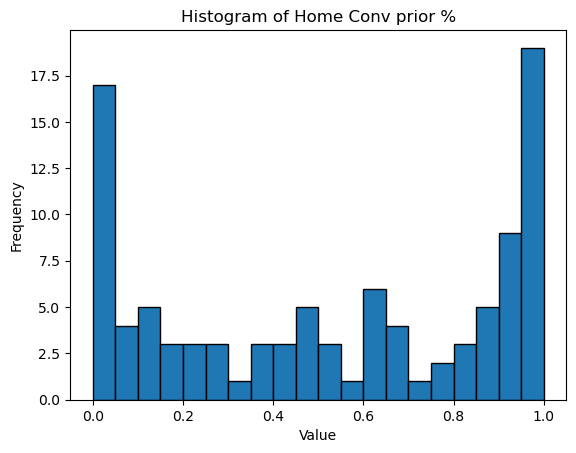

In [81]:
# Plot Prior predictive
# This should be the reasonable kicking percentage for a team

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

all_home_conv_prior = az.extract(prior_samples.prior['p_home_conv'])

# Create a histogram
plt.hist(all_home_conv_prior.p_home_conv[0].values, bins=20, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Home Conv prior %')

# Show the plot
plt.show()

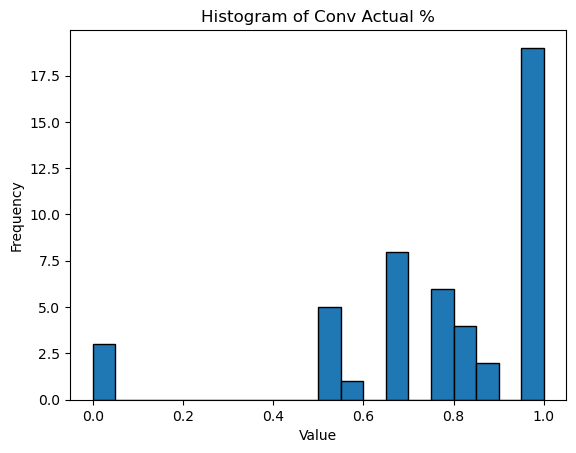

In [82]:
# Plot actual data

import numpy as np
import matplotlib.pyplot as plt

# Create a histogram
#plt.hist(home_tries_conv['home_conv_per'].values, bins=20, edgecolor='black')  # Adjust bins as needed
plt.hist(union_conv['conv_per'].values, bins=20, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Conv Actual %')

# Show the plot
plt.show()




In [83]:
# Create Model for kicker and see what examples look like
# don't specify seed - it can put results off - you get a good run with seed
with kicker_model:
    kicker_trace = pm.sample(1000, tune=2000, cores=4, return_inferencedata=True)


import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(kicker_trace.posterior, round_to=2)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(summary_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kick_mu, kick_sd, kick]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.


                 mean    sd  hdi_3%  hdi_97%  r_hat
kick_mu          1.27  0.19    0.92     1.61   1.01
kick[0]          1.26  0.26    0.78     1.76   1.02
kick[1]          1.26  0.26    0.75     1.75   1.01
kick[2]          1.23  0.31    0.61     1.80   1.01
kick[3]          1.24  0.26    0.71     1.73   1.01
kick[4]          1.22  0.33    0.63     1.89   1.01
kick[5]          1.28  0.28    0.77     1.83   1.01
kick[6]          1.33  0.32    0.76     1.93   1.01
kick[7]          1.26  0.30    0.72     1.85   1.02
kick[8]          1.25  0.29    0.71     1.81   1.01
kick[9]          1.25  0.30    0.72     1.86   1.01
kick[10]         1.32  0.29    0.77     1.87   1.01
kick[11]         1.25  0.26    0.78     1.79   1.01
kick[12]         1.32  0.32    0.74     1.93   1.01
kick[13]         1.27  0.27    0.77     1.79   1.01
kick[14]         1.28  0.27    0.79     1.80   1.01
kick[15]         1.29  0.32    0.65     1.88   1.01
kick[16]         1.28  0.30    0.72     1.85   1.01
kick[17]    

In [31]:
# Apply
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(4)

0.9820137900379085

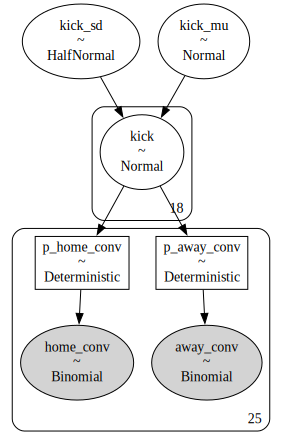

In [84]:
# Graph Model
# I think sigma away points should be in the atts box
pm.model_to_graphviz(kicker_model)

In [85]:
# Apply
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# use sigmoid to gegt mean probability
print('min sigmoid: ',sigmoid(1.08) )
print('max sigmoid: ',sigmoid(1.18) )

min sigmoid:  0.7464939833376621
max sigmoid:  0.7649478037637647


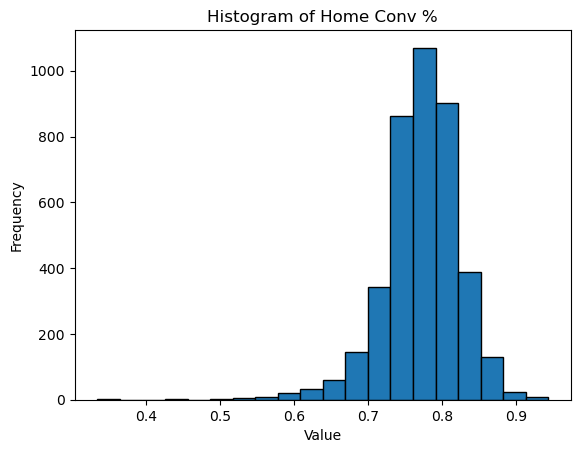

In [85]:
import numpy as np
import matplotlib.pyplot as plt

all_home_conv_draws = az.extract(kicker_trace.posterior['p_home_conv'])

# Create a histogram
plt.hist(all_home_conv_draws.p_home_conv[0].values, bins=20, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Home Conv %')

# Show the plot
plt.show()

In [ ]:
import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(trace.posterior, round_to=2)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
def replace_index_with_team_name(index, mapping):
    # Match patterns like "atts[0]" or "defs[0]" and replace "0" with the team name
    if index.startswith("atts[") or index.startswith("defs["):
        # Extract the parameter type (e.g., "atts" or "defs") and the team index
        param_type = index.split("[")[0]
        team_index = int(index.split("[")[1].strip("]"))  # Extract the number inside brackets
        
        # Find the corresponding team name from the mapping
        for team, num in mapping.items():
            if num == team_index:
                return f"{param_type}[{team}]"
    return index  # Leave other rows unchanged

summary_df = summary_df.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))

# Save as csv
summary_df.to_csv('summary_df_nb_new_data.csv')

# Display the updated DataFrame
print(summary_df)

In [ ]:
az.extract(away_data)

In [293]:
# Use Negative Binomial Model


import pymc as pm

# Create Model
with pm.Model() as nb_model:
    home_param_tries = pm.Normal("home_param_tries", 0, 0.5)
    home_param_pg_dg = pm.Normal("home_param_pg_dg", 0, 0.5)

    # Attack ratings for teams - common mu and sd that all teams draw from
    atts_mu_tries = pm.Normal("atts_mu_tries", 0, 0.5)
    atts_sd_tries = pm.HalfNormal("atts_sd_tries", 0.5)
    atts_tries = pm.Normal("atts_tries", mu=atts_mu_tries, sigma=atts_sd_tries, shape=n_teams)

    # Defence ratings for teams - common mu and sd that all teams draw from
    defs_mu_tries = pm.Normal("defs_mu_tries", 0, 0.5)
    defs_sd_tries = pm.HalfNormal("defs_sd_tries", 0.5)
    defs_tries = pm.Normal("defs_tries", mu=defs_mu_tries, sigma=defs_sd_tries, shape=n_teams)

    # Attack ratings for teams - penalties
    atts_mu_pg_dg = pm.Normal("atts_mu_pg_dg", 0, 0.5)
    atts_sd_pg_dg = pm.HalfNormal("atts_sd_pg_dg", 0.5)
    atts_pg_dg = pm.Normal("atts_pg_dg", mu=atts_mu_pg_dg, sigma=atts_sd_pg_dg, shape=n_teams)

    # Defence ratings for teams - common mu and sd that all teams draw from
    defs_mu_pg_dg = pm.Normal("defs_mu_pg_dg", 0, 0.5)
    defs_sd_pg_dg = pm.HalfNormal("defs_sd_pg_dg", 0.5)
    defs_pg_dg = pm.Normal("defs_pg_dg", mu=defs_mu_pg_dg, sigma=defs_sd_pg_dg, shape=n_teams)


    # Create a parameter for kickers - wide priors
    kick_mu = pm.Normal("kick_mu", 0, 3)
    kick_sd = pm.HalfNormal("kick_sd", 3)
    kick = pm.Normal("kick", mu=kick_mu, sigma=kick_sd, shape=n_teams)
    
    # Calculate theta for tries

    # Register away_theta and home_theta as a deterministic variable
    home_tries_theta = pm.Deterministic("home_tries_theta", pm.math.exp(home_param_tries + atts_tries[home_team] + defs_tries[away_team]))
    away_tries_theta = pm.Deterministic("away_tries_theta", pm.math.exp(atts_tries[away_team] + defs_tries[home_team]))

    # Create alpha - Gamma shape parameter
    alpha_home_tries = pm.HalfNormal("alpha_home_tries",2)
    alpha_away_tries = pm.HalfNormal("alpha_away_tries",2)

    # Negative Binomial for tries
    home_tries_nb = pm.NegativeBinomial("home_tries_nb",mu=home_tries_theta, 
                                      alpha=alpha_home_tries, 
                                        observed=home_tries)
    away_tries_nb = pm.NegativeBinomial("away_tries_nb",mu=away_tries_theta, 
                                     alpha=alpha_away_tries,observed=away_tries)


    # Get p for home conv and away
    # This should only depend on the kicker for that team - removed home advantage
    p_home_conv = pm.Deterministic("p_home_conv", pm.math.invlogit(kick[home_team] ))
    p_away_conv = pm.Deterministic("p_away_conv", pm.math.invlogit(kick[away_team] ) )

    # Estimating p_home_conv and p_away_conv here - have data for n and observed
    # Changed N to home_tries_nb from home_tries
    home_conv_bin =  pm.Binomial("home_conv_bin", n=home_tries_nb, p=p_home_conv, observed= home_conv)
    away_conv_bin =  pm.Binomial("away_conv_bin", n=away_tries_nb, p=p_away_conv, observed= away_conv)

    # Calculate theta for penalties and drop goals

    # Register away_theta and home_theta as a deterministic variable
    home_pg_dg_theta = pm.Deterministic("home_pg_dg_theta", pm.math.exp(home_param_pg_dg
                                                                        + atts_pg_dg[home_team]
                                                                        + defs_pg_dg[away_team]))
    away_pg_dg_theta = pm.Deterministic("away_pg_dg_theta", pm.math.exp(atts_pg_dg[away_team]
                                                                        + defs_pg_dg[home_team]))

    # Create alpha - Gamma shape parameter for penalties
    alpha_home_pg_dg = pm.HalfNormal("alpha_home_pg_dg",2)
    alpha_away_pg_dg = pm.HalfNormal("alpha_away_pg_dg",2)

    # Negative Binomial for tries
    home_pg_dg_nb = pm.NegativeBinomial("home_pg_dg_nb",mu=home_pg_dg_theta, 
                                      alpha=alpha_home_pg_dg, 
                                        observed=home_pg_dg)
    away_pg_dg_nb = pm.NegativeBinomial("away_pg_dg_nb",mu=away_pg_dg_theta, 
                                     alpha=alpha_away_pg_dg,
                                        observed=away_pg_dg)

    # Get prior samples
    prior_samples = pm.sample_prior_predictive(100)


# Create Model
with nb_model:
    trace = pm.sample(100, tune=200, cores=4, return_inferencedata=True)


# Define home_score_model and away_score_model in posterior predictive step
with nb_model:
    home_score_model = pm.Deterministic("home_score_model", home_tries_nb * 5 + home_conv_bin * 2 + home_pg_dg_nb * 3)
    away_score_model = pm.Deterministic("away_score_model", away_tries_nb * 5 + away_conv_bin * 2 + away_pg_dg_nb * 3)
    
    # Sample from posterior predictive
    #pm.sample_posterior_predictive(trace, var_names=["home_score_model", "away_score_model"])
    posterior_predictive_samples = pm.sample_posterior_predictive(trace,extend_inferencedata=True)

Sampling: [alpha_away_pg_dg, alpha_away_tries, alpha_home_pg_dg, alpha_home_tries, atts_mu_pg_dg, atts_mu_tries, atts_pg_dg, atts_sd_pg_dg, atts_sd_tries, atts_tries, away_conv_bin, away_pg_dg_nb, away_tries_nb, defs_mu_pg_dg, defs_mu_tries, defs_pg_dg, defs_sd_pg_dg, defs_sd_tries, defs_tries, home_conv_bin, home_param_pg_dg, home_param_tries, home_pg_dg_nb, home_tries_nb, kick, kick_mu, kick_sd]
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_param_tries, home_param_pg_dg, atts_mu_tries, atts_sd_tries, atts_tries, defs_mu_tries, defs_sd_tries, defs_tries, atts_mu_pg_dg, atts_sd_pg_dg, atts_pg_dg, defs_mu_pg_dg, defs_sd_pg_dg, defs_pg_dg, kick_mu, kick_sd, kick, alpha_home_tries, alpha_away_tries, alpha_home_pg_dg, alpha_away_pg_dg]


Sampling 4 chains for 200 tune and 100 draw iterations (800 + 400 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [away_conv_bin, away_pg_dg_nb, away_tries_nb, home_conv_bin, home_pg_dg_nb, home_tries_nb]


In [308]:
# Check Trace - confirmed only 27 variables in Posterior
# i think adding extend_inferencedata=True will add posterior predictive to trace
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [309]:
# Check Posterior predictive - confirmed has 8 variables
posterior_predictive_samples

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [310]:
# Combine chain and draw data into 1 sample and round to integers
home_tries_chains = az.extract(posterior_predictive_samples.posterior_predictive.home_tries_nb.values)
home_conv_chains = az.extract(posterior_predictive_samples.posterior_predictive.home_conv_bin.values)

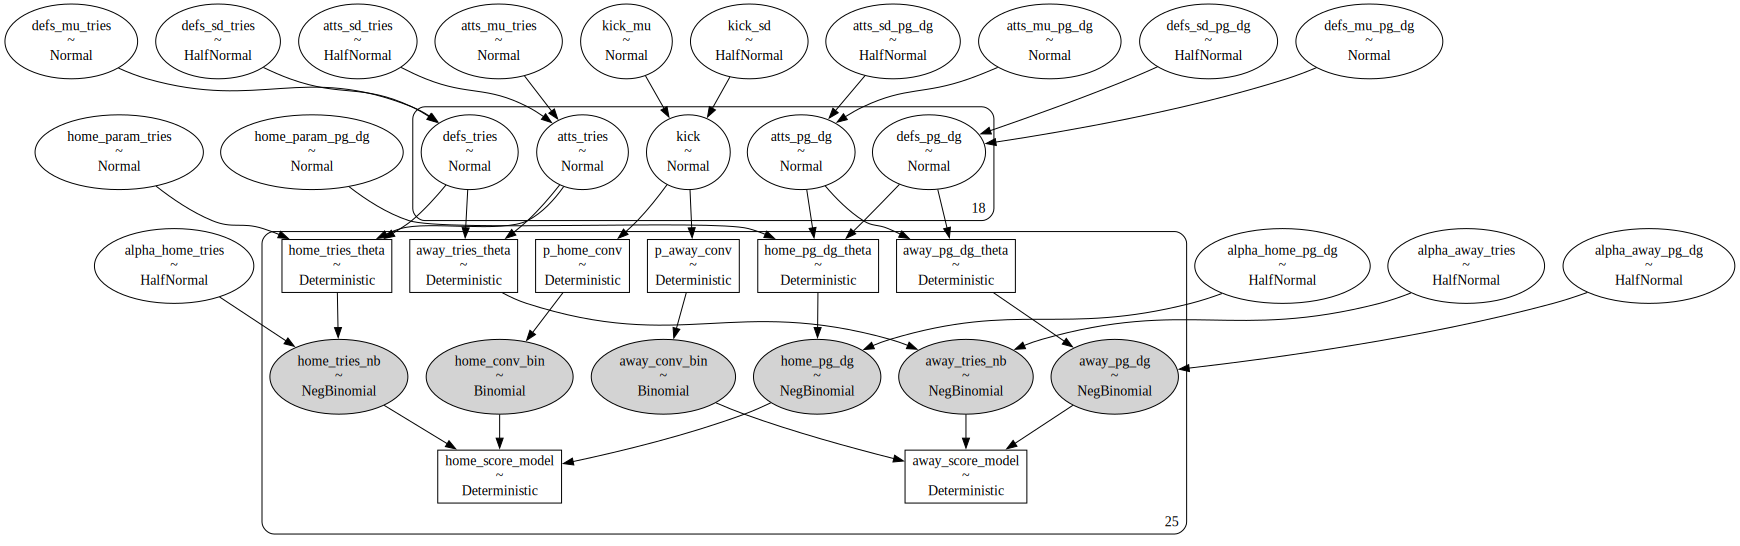

In [301]:
# Graph Model
# I think sigma away points should be in the atts box
# Number of penalties and number of tries are correlated
# They are negatively correlated - as number of tries increases number of penalties drops
# When 2 teams are close they can cancel each other out - less tries

pm.model_to_graphviz(model)

In [315]:
# Get summary of trace
# Priors seem to be quite strong

import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(trace.posterior, round_to=2)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
def replace_index_with_team_name(index, mapping):
    # Match patterns like "atts[0]" or "defs[0]" and replace "0" with the team name
    if index.startswith("atts_tries[") or index.startswith("defs_tries[") or index.startswith("kick[") or index.startswith("atts_pg_dg[") or index.startswith("defs_pg_dg["):
        # Extract the parameter type (e.g., "atts" or "defs") and the team index
        param_type = index.split("[")[0]
        team_index = int(index.split("[")[1].strip("]"))  # Extract the number inside brackets
        
        # Find the corresponding team name from the mapping
        for team, num in mapping.items():
            if num == team_index:
                return f"{param_type}[{team}]"
    return index  # Leave other rows unchanged

summary_df = summary_df.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))

# Save as csv
#summary_df.to_csv('summary_df_nb_new_data.csv')

# Display the updated DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(summary_df)




                          mean    sd  hdi_3%  hdi_97%  r_hat
home_param_tries          0.02  0.20   -0.38     0.35   1.02
home_param_pg_dg         -0.08  0.28   -0.58     0.45   1.04
atts_mu_tries             0.63  0.35   -0.04     1.23   1.15
atts_tries[Argentina]     0.79  0.43    0.06     1.55   1.10
atts_tries[Australia]     0.65  0.38    0.02     1.46   1.06
atts_tries[Chile]         0.60  0.42   -0.13     1.38   1.12
atts_tries[England]       0.70  0.39    0.00     1.36   1.08
atts_tries[Fiji]          0.60  0.44   -0.12     1.38   1.08
atts_tries[France]        0.67  0.41   -0.08     1.37   1.11
atts_tries[France A]      0.61  0.41   -0.11     1.38   1.08
atts_tries[Georgia]       0.60  0.38    0.02     1.40   1.16
atts_tries[Ireland]       0.61  0.40   -0.08     1.35   1.10
atts_tries[Italy]         0.62  0.39   -0.05     1.38   1.13
atts_tries[Japan]         0.55  0.37   -0.11     1.30   1.11
atts_tries[New Zealand]   0.71  0.41   -0.01     1.39   1.10
atts_tries[Portugal]    

Home score mean:  28.6
Home score std:  15.136710342739601


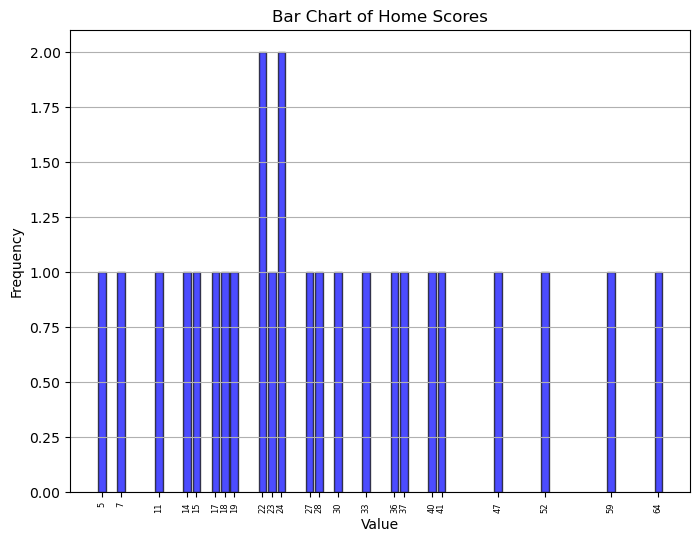

Away score mean:  31.68
Away score std:  17.68099544708951


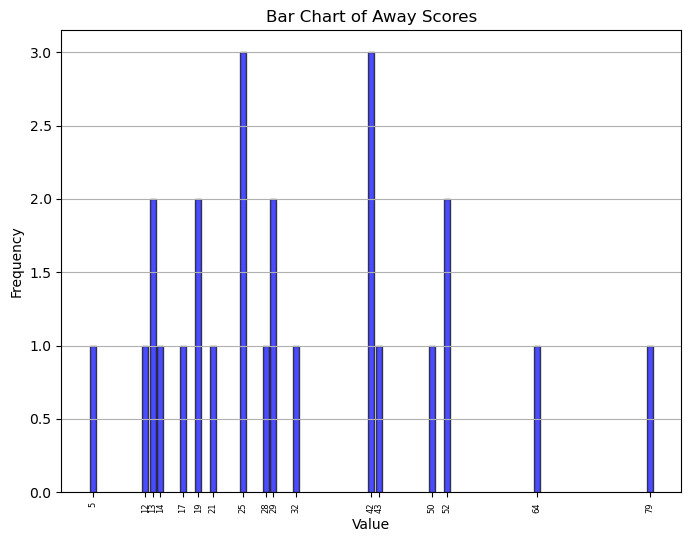

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Plot Home Scores
# Get statistics
print('Home score mean: ', np.mean(home_score_arr))
print('Home score std: ', np.std(home_score_arr))

# Count frequencies for each unique score
home_score_counts = Counter(home_score_arr)
unique_home_scores = sorted(home_score_counts.keys())
home_frequencies = [home_score_counts[score] for score in unique_home_scores]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_home_scores, home_frequencies, color="blue", edgecolor="black", alpha=0.7)

# Add x ticks
plt.xticks(unique_home_scores, rotation=90, fontsize=6)

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bar Chart of Home Scores")
plt.grid(axis="y")
plt.show()

# Plot Away Scores
# Get statistics
print('Away score mean: ', np.mean(away_score_arr))
print('Away score std: ', np.std(away_score_arr))

# Count frequencies for each unique score
away_score_counts = Counter(away_score_arr)
unique_away_scores = sorted(away_score_counts.keys())
away_frequencies = [away_score_counts[score] for score in unique_away_scores]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_away_scores, away_frequencies, color="blue", edgecolor="black", alpha=0.7)

# Add x ticks
plt.xticks(unique_away_scores, rotation=90, fontsize=6)

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bar Chart of Away Scores")
plt.grid(axis="y")
plt.show()


Away score mean:  26.76
Away score std:  18.19731848377667


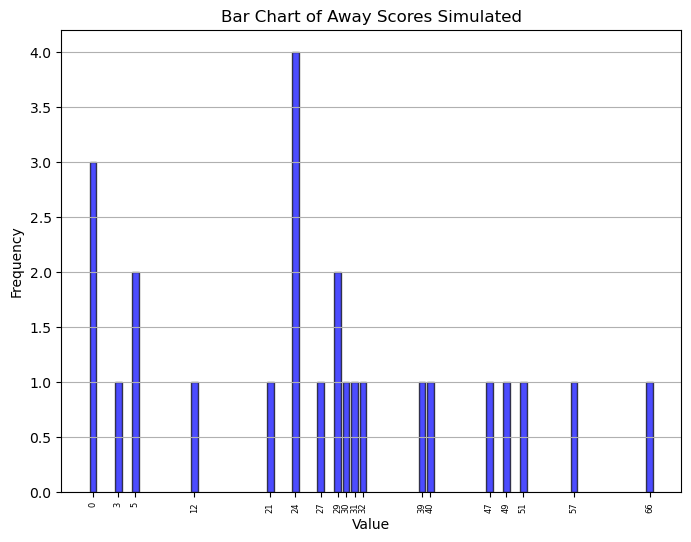

In [304]:
# Plot a Sample of the away scores for comparisson

sample_model_away = posterior_predictive_samples.posterior_predictive.away_score_model[0,0,:].values



# Plot Away Scores
# Get statistics
print('Away score mean: ', np.mean(sample_model_away))
print('Away score std: ', np.std(sample_model_away))

# Count frequencies for each unique score
away_score_counts = Counter(sample_model_away)
unique_away_scores = sorted(away_score_counts.keys())
away_frequencies = [away_score_counts[score] for score in unique_away_scores]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_away_scores, away_frequencies, color="blue", edgecolor="black", alpha=0.7)

# Add x ticks
plt.xticks(unique_away_scores, rotation=90, fontsize=6)

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bar Chart of Away Scores Simulated")
plt.grid(axis="y")
plt.show()




<Axes: >

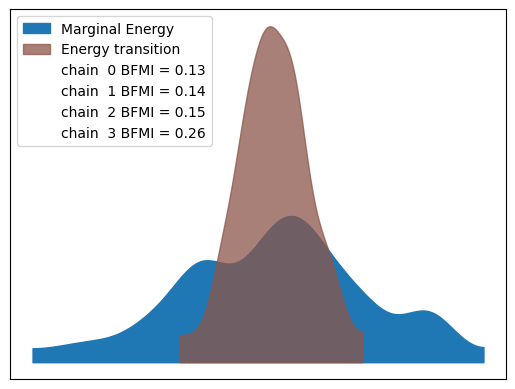

In [305]:
# Unsure what this plot is
# Distributions are not similar so must be something wrong
# This seems the best one so far
az.plot_energy(trace)

array([[<Axes: title={'center': 'atts_mu_tries'}>,
        <Axes: title={'center': 'atts_mu_tries'}>]], dtype=object)

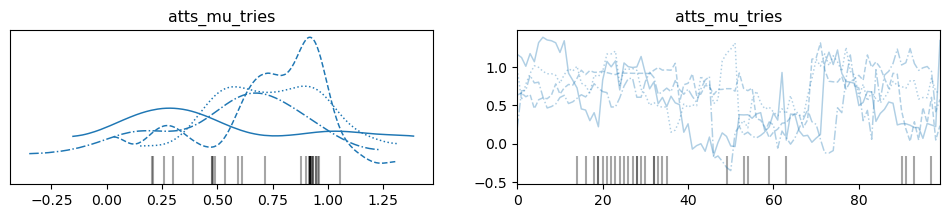

In [318]:
# Plot doesn't look like it has converged
az.plot_trace(trace, var_names=["atts_mu_tries"])

C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
C:\Users\killi\anaconda3\envs\pymc5\Lib\site-packages\arviz\plots\ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


array([[<Axes: xlabel='home_tries_nb / home_tries_nb'>,
        <Axes: xlabel='away_tries_nb / away_tries_nb'>,
        <Axes: xlabel='home_conv_bin / home_conv_bin'>],
       [<Axes: xlabel='away_conv_bin / away_conv_bin'>,
        <Axes: xlabel='home_pg_dg_nb / home_pg_dg_nb'>,
        <Axes: xlabel='away_pg_dg_nb / away_pg_dg_nb'>]], dtype=object)

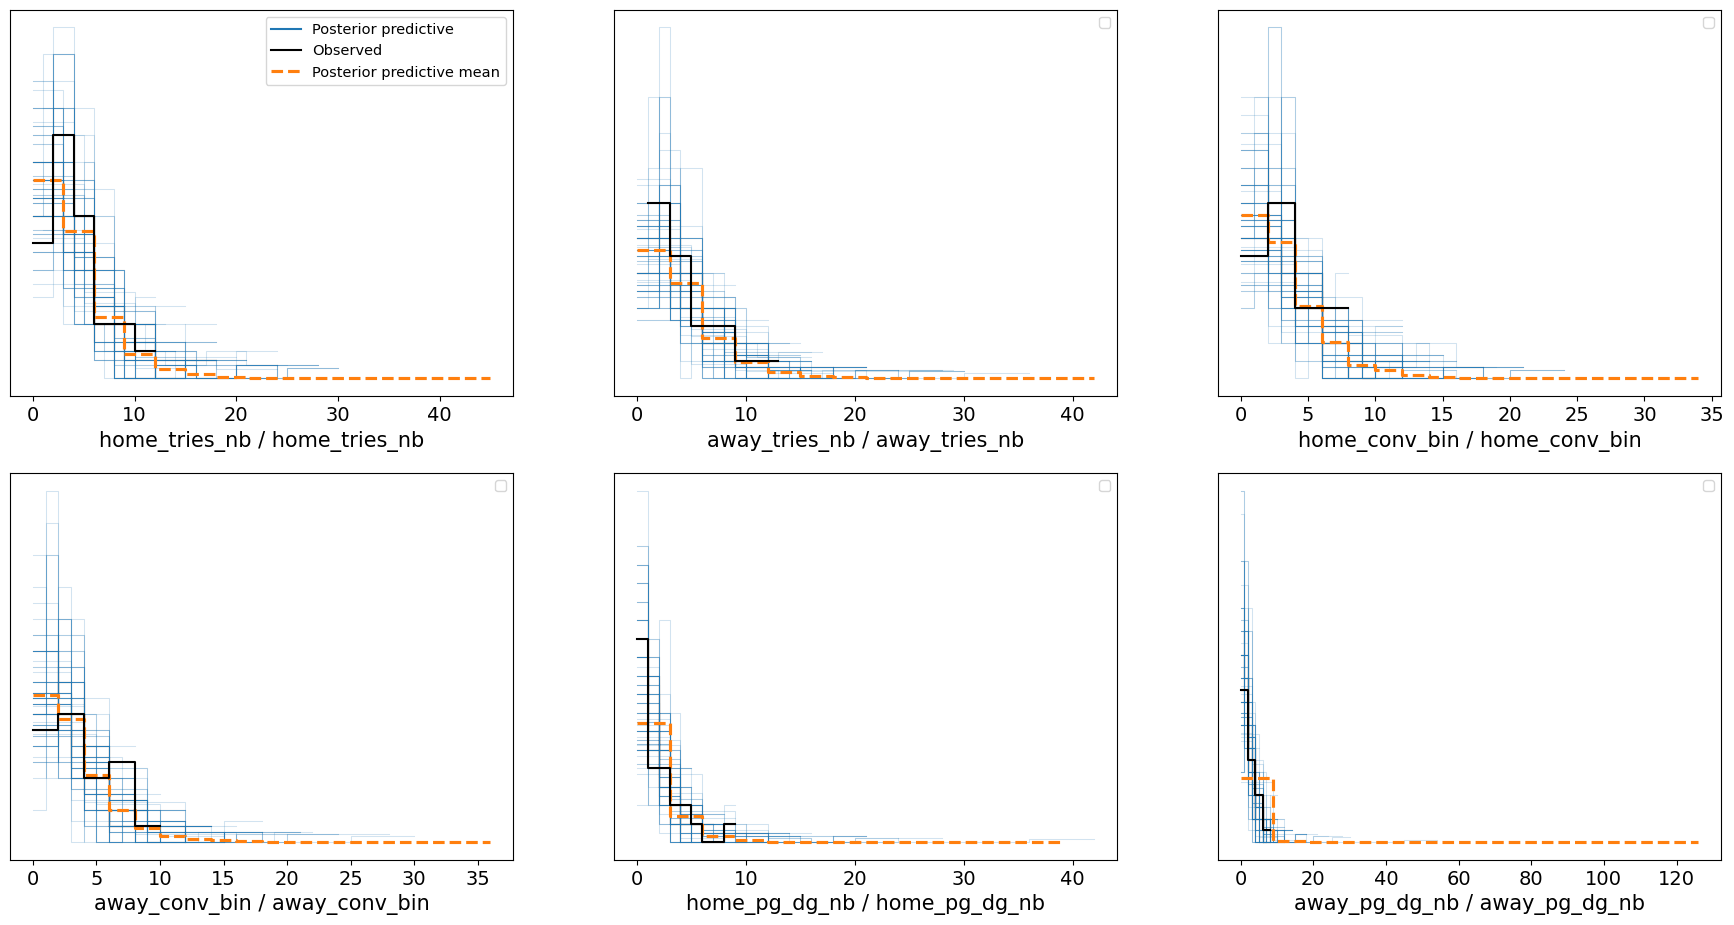

In [316]:
# Plot Posterior Predictive check
# There seems to be too much data in the tails


az.plot_ppc(trace, num_pp_samples=100)

In [321]:
home_data = posterior_predictive_samples.posterior_predictive.home_score_model

# Initialize a list to store results
home_results = []

for i in range(25):
    p2_5 = np.percentile(home_data[:,:,i], 2.5)
    p16 = np.percentile(home_data[:,:,i], 16)
    p25 = np.percentile(home_data[:,:,i], 25)
    p50 = np.percentile(home_data[:,:,i], 50)
    mean = np.mean(home_data[:,:,i]).values
    std = np.std(home_data[:,:,i]).values
    p75 = np.percentile(home_data[:,:,i], 75)
    p84 = np.percentile(home_data[:,:,i], 84)
    p97_5 = np.percentile(home_data[:,:,i], 97.5)

    # Append the results as a dictionary
    home_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
home_points_df = pd.DataFrame(home_results)

In [322]:
away_data = posterior_predictive_samples.posterior_predictive.away_score_model

# Initialize a list to store results
away_results = []

for i in range(25):
    p2_5 = np.percentile(away_data[:,:,i], 2.5)
    p16 = np.percentile(away_data[:,:,i], 16)
    p25 = np.percentile(away_data[:,:,i], 25)
    p50 = np.percentile(away_data[:,:,i], 50)
    mean = np.mean(away_data[:,:,i]).values
    std = np.std(away_data[:,:,i]).values
    p75 = np.percentile(away_data[:,:,i], 75)
    p84 = np.percentile(away_data[:,:,i], 84)
    p97_5 = np.percentile(away_data[:,:,i], 97.5)

    # Append the results as a dictionary
    away_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
away_points_df = pd.DataFrame(away_results)

In [325]:
# Combine chain and draw data into 1 sample and round to integers
away_draw_chains =  az.extract(away_data).away_score_model.values
home_draw_chains = az.extract(home_data).home_score_model.values

# Perform element-wise comparisons for all columns
home_win = np.sum(home_draw_chains > away_draw_chains, axis=1) 
away_win = np.sum(home_draw_chains < away_draw_chains, axis=1)  
draw = np.sum(home_draw_chains == away_draw_chains, axis=1)  

# Calculate percentages
total_comparisons = home_draw_chains.shape[1]
percent_home_win = (home_win / total_comparisons) * 100
percent_away_win = (away_win / total_comparisons) * 100
percent_draw = (draw / total_comparisons) * 100

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    "Home Win (%)": percent_home_win,
    "Away Win (%)": percent_away_win,
    "Draw (%)": percent_draw,
})

# Display the summary DataFrame
print(summary_stats)


    Home Win (%)  Away Win (%)  Draw (%)
0          54.75         43.50      1.75
1          68.25         29.25      2.50
2          59.25         37.50      3.25
3          40.25         57.00      2.75
4          49.00         47.25      3.75
5          49.25         48.75      2.00
6          70.25         28.50      1.25
7          39.75         58.00      2.25
8          51.00         48.00      1.00
9          24.50         74.25      1.25
10         34.50         64.25      1.25
11         31.25         67.00      1.75
12         28.25         70.25      1.50
13         67.50         30.50      2.00
14         54.75         43.75      1.50
15         63.00         34.50      2.50
16         58.00         40.75      1.25
17         51.00         45.75      3.25
18         41.00         57.00      2.00
19         51.75         45.75      2.50
20         58.75         39.50      1.75
21         37.25         60.25      2.50
22         36.50         62.00      1.50
23         61.50

In [327]:
friendly_int.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'key',
       'Home_tries', 'Away_tries', 'Home_conv', 'Away_conv', 'Home_conv_att',
       'Away_conv_att', 'Home_pg', 'Away_pg', 'Home_pg_att', 'Away_pg_att',
       'Home_dg', 'Away_dg', 'Home_dg_att', 'Away_dg_att', 'home_num',
       'away_num', 'Home_pg_dg', 'Away_pg_dg', 'manual_score_home',
       'manual_score_away', 'Home_diff', 'Away_diff'],
      dtype='object')

In [358]:

# Merge actual back to sim for home
join_home = pd.merge(home_points_df,friendly_int[['home_team','home_score']],left_index=True, right_index=True)

join_home['Mean'] = join_home['Mean'].astype(float)

# Round to 2 decimal places
join_home = join_home.round(2)

# create flag columns
join_home['95_flag'] = join_home.apply(lambda row: 1 if row['p2_5'] <= row['home_score'] <= row['p97_5'] else 0,axis=1)
join_home['68_flag'] = join_home.apply(lambda row: 1 if row['p16'] <= row['home_score'] <= row['p84'] else 0,axis=1)
join_home['50_flag'] = join_home.apply(lambda row: 1 if row['p25'] <= row['home_score'] <= row['p75'] else 0,axis=1)


# Select new columns
join_home = join_home[['home_team','home_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_home['95_flag'].sum()/join_home['95_flag'].count(),2))
print('68% rate: ',round(join_home['68_flag'].sum()/join_home['68_flag'].count(),2))
print('50% rate: ',round(join_home['50_flag'].sum()/join_home['50_flag'].count(),2))


# Merge actual back to sim for away
join_away = pd.merge(away_points_df, friendly_int[['away_team','away_score']],left_index=True, right_index=True)

join_away['Mean'] = join_away['Mean'].astype(float)

# Round to 2 decimal places
join_away = join_away.round(2)


# create flag columns
join_away['95_flag'] = join_away.apply(lambda row: 1 if row['p2_5'] <= row['away_score'] <= row['p97_5'] else 0,axis=1)
join_away['68_flag'] = join_away.apply(lambda row: 1 if row['p16'] <= row['away_score'] <= row['p84'] else 0,axis=1)
join_away['50_flag'] = join_away.apply(lambda row: 1 if row['p25'] <= row['away_score'] <= row['p75'] else 0,axis=1)

# Select new columns
join_away = join_away[['away_team','away_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_away['95_flag'].sum()/join_away['95_flag'].count(),2))
print('68% rate: ',round(join_away['68_flag'].sum()/join_away['68_flag'].count(),2))
print('50% rate: ',round(join_away['50_flag'].sum()/join_away['50_flag'].count(),2))


# Merge actual back to sim for away
join_all_flags = pd.merge(join_home, join_away,left_index=True, right_index=True)

join_all_flags = join_all_flags[['home_team', 'home_score', 
                                 'away_team', 'away_score',
                                 'Mean_x','std_x', '95_flag_x', '68_flag_x',
       '50_flag_x',  'Mean_y','std_y', '95_flag_y',
       '68_flag_y', '50_flag_y']]

# calculate residuals
# Originally avg 8.66 home, 10.66 away
# New model slightly better 8.55 home and 10.65 away
# Down to 7.78 and 9.8 - could be the sim

join_all_flags['home_resid'] = join_all_flags['home_score'] - join_all_flags['Mean_x']
join_all_flags['away_resid'] = join_all_flags['away_score'] - join_all_flags['Mean_y']

# Create absolute column
join_all_flags['home_resid_abs'] = join_all_flags['home_resid'].abs()
join_all_flags['away_resid_abs'] = join_all_flags['away_resid'].abs()

home_rmse = np.sqrt(np.mean((join_all_flags['home_resid']) ** 2))
away_rmse = np.sqrt(np.mean((join_all_flags['away_resid']) ** 2))

print('home_rmse: ',home_rmse)
print('away_rmse: ',away_rmse)

# Originally 39%, this increased to 41%
# R squared also increased to 51%
from sklearn.metrics import r2_score

# Compare observed and predicted data
r2 = r2_score(join_all_flags['home_score'].values, join_all_flags['Mean_x'].values)
print(f"R-squared: {r2}")

# Join summary stats
join_percentages = pd.merge(join_all_flags,summary_stats,left_index=True,right_index=True)

# round to 2 decimal places
# Convert the  column to numeric (float)
join_percentages['std_x'] = join_percentages['std_x'].astype(float)
join_percentages['std_x'] = join_percentages['std_x'].round(2)

join_percentages['std_y'] = join_percentages['std_y'].astype(float)
join_percentages['std_y'] = join_percentages['std_y'].round(2)

# Calculate Odds
join_percentages['home_odds'] = (100/join_percentages['Home Win (%)']).round(2)
join_percentages['away_odds'] = (100/join_percentages['Away Win (%)']).round(2)
join_percentages['draw_odds'] = (100/join_percentages['Draw (%)']).round(2)

 



95% rate:  1.0
68% rate:  0.96
50% rate:  0.84
95% rate:  1.0
68% rate:  0.92
50% rate:  0.76
home_rmse:  10.408085318635699
away_rmse:  12.001420749227984
R-squared: 0.5271986731843576


In [352]:
# This is good for analysing residuals and seeing where prediction went wrong
# Think sd for all teams is too restrictive
join_percentages.to_csv('join_percentages_nb_new_data.csv')

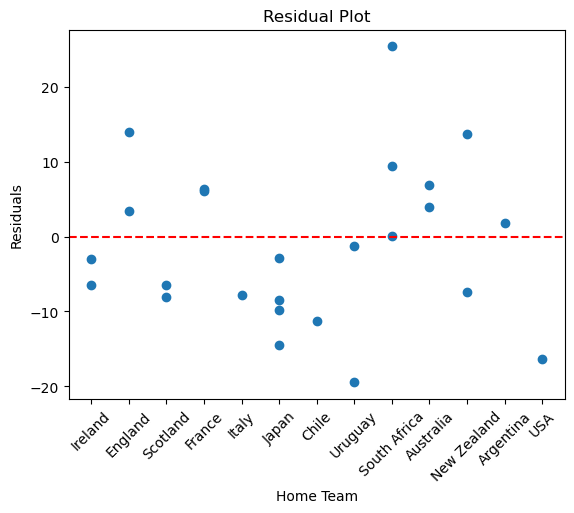

In [353]:
# Plot residuals for home score
# Residual is Actual - Mean score
# So negative means underperformed
import matplotlib.pyplot as plt

plt.scatter(join_all_flags['home_team'], join_all_flags['home_resid'].values)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Home Team")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.xticks(rotation=45)
plt.show()

In [360]:
# These odds arn't accurate reflections as we already have the results for these prices
# The odds should only be determined from the previous results
# However I don't have any data here
# I need to start scraping more
# 6 nations at least before getting a prediction for these internationals

join_percentages[join_percentages['home_team'] == 'Ireland'][['home_team', 'home_score', 'away_team', 
                                                              'away_score', 'Mean_x', 'std_x',
        'Mean_y', 'std_y', 'home_resid', 
       'away_resid_abs', 'home_odds', 'away_odds', 'draw_odds']]


,home_team,home_score,away_team,away_score,Mean_x,std_x,Mean_y,std_y,home_resid,away_resid_abs,home_odds,away_odds,draw_odds
0,Ireland,22,Australia,19,28.47,21.32,24.82,17.86,-6.47,5.82,1.83,2.30,57.14
4,Ireland,22,Argentina,19,24.94,18.62,26.12,26.99,-2.94,7.12,2.04,2.12,26.67


In [354]:
join_percentages.columns

Index(['home_team', 'home_score', 'away_team', 'away_score', 'Mean_x', 'std_x',
       '95_flag_x', '68_flag_x', '50_flag_x', 'Mean_y', 'std_y', '95_flag_y',
       '68_flag_y', '50_flag_y', 'home_resid', 'away_resid', 'home_resid_abs',
       'away_resid_abs', 'Home Win (%)', 'Away Win (%)', 'Draw (%)',
       'home_odds', 'away_odds', 'draw_odds'],
      dtype='object')